

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [22]:
!pip install -U torch torchvision

In [23]:
import torch

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [24]:
# # нам необходима версия pillow  5.3.0
# # удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
# import PIL
# print(PIL.PILLOW_VERSION)
# # здесь должна быть версия 5.3.0. если это не так перезагрузите данный ноутбук:
# # Menu > Runtime > Restart Runtime

In [25]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F

from matplotlib import colors, pyplot as plt
%matplotlib inline
import seaborn as sns

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [26]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [27]:
# буду загружать данные с kaggle сразу в ноутбук, 
! pip install kaggle==1.5.6

In [28]:
! mkdir /.kaggle

mkdir: cannot create directory ‘/.kaggle’: File exists


In [29]:
! cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/

In [30]:
! chmod 600 ~/.kaggle/kaggle.json

In [31]:
! kaggle competitions download -c journey-springfield
! unzip -q /content/journey-springfield.zip

 99% 515M/521M [00:05<00:00, 141MB/s]
100% 521M/521M [00:05<00:00, 106MB/s]


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [32]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224

посмотрю данные

In [33]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

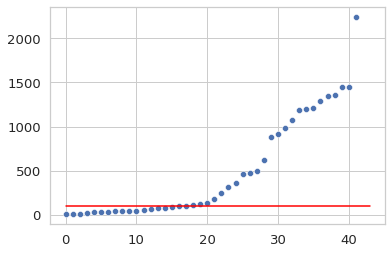

In [34]:
cnts = {}

for path in train_val_files:
    if cnts.get(path.parent.name) is not None:
        cnts[path.parent.name] += 1
    else:
        cnts[path.parent.name] = 1

sns.set(style="whitegrid", font_scale=1.2)
sns.lineplot(x=(0, 43), y=(100, 100), color='red')
sns.scatterplot(data=sorted(cnts.values()))

картина совсем не очень

попробую добавить примеров за счёт аугментации

In [35]:
!pip install -U albumentations

In [36]:
import albumentations as A

In [37]:
a_transform = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Sharpen(p=0.3),
    A.SafeRotate(p=0.5),
    A.OpticalDistortion(p=0.1)
])

Разбавлю датасет различными вариантами исходных фотографий чтобы для каждого класса было хотя бы 650 изображений


In [142]:
for i, item in enumerate(cnts):
    print(i, item)  # номер и название класса
    working_dir = TRAIN_DIR / item
    images = list(working_dir.rglob('*.jpg'))
    while len(images) < 650:
        random_id = int(np.random.randint(0, len(images)))  # случайный id картинки из уже имеющихся
        image = np.array(Image.open(images[random_id]))  # случайная картинка 

        transformed = a_transform(image=image)["image"]

        # сгенерирую уникальное название чтобы не делать одну и ту же работу много раз
        name = images[random_id].name.split('_')
        if not images[random_id].name.startswith('copy'):
            new_name = f"copy_0_{images[random_id].name}"
            name = ['copy', '0'] + name
            num = 0
        else:
            num = int(name[1]) + 1
        # если такое название уже существует, то буду увеличивать цифру после copy (в предыдущем блоке copy обязательно появляется)
        while working_dir / new_name in images:
            num += 1
            new_name = f"copy_{num}_{'_'.join(name[2:])}"
        
        j = Image.fromarray(image, mode='RGB')
        j.save(working_dir / new_name)

        images.append(working_dir / new_name)

0 abraham_grampa_simpson
1 agnes_skinner
2 apu_nahasapeemapetilon
3 barney_gumble
4 bart_simpson
5 carl_carlson
6 charles_montgomery_burns
7 chief_wiggum
8 cletus_spuckler
9 comic_book_guy
10 disco_stu
11 edna_krabappel
12 fat_tony
13 gil
14 groundskeeper_willie
15 homer_simpson
16 kent_brockman
17 krusty_the_clown
18 lenny_leonard
19 lionel_hutz
20 lisa_simpson
21 maggie_simpson
22 marge_simpson
23 martin_prince
24 mayor_quimby
25 milhouse_van_houten
26 miss_hoover
27 moe_szyslak
28 ned_flanders
29 nelson_muntz
30 otto_mann
31 patty_bouvier
32 principal_skinner
33 professor_john_frink
34 rainier_wolfcastle
35 ralph_wiggum
36 selma_bouvier
37 sideshow_bob
38 sideshow_mel
39 snake_jailbird
40 troy_mcclure
41 waylon_smithers


https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [39]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        image = transforms.functional.pad(image, padding, 0, 'constant')
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [40]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [41]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [42]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [43]:
val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Давайте посмотрим на наших героев внутри датасета.

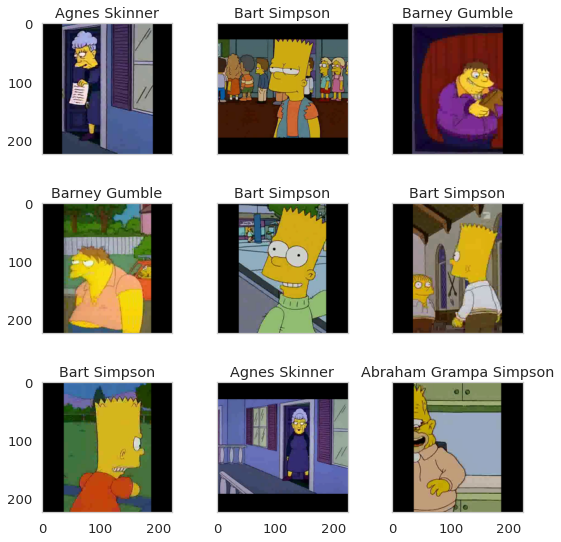

In [44]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
             title=img_label,plt_ax=fig_x)

plt.tight_layout()

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [45]:
# моя очень простая сеть
class MySimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [46]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [47]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [48]:
def train(train_files, val_files, model, criterion, optimizer, scheduler, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = criterion

        for epoch in range(epochs):
            scheduler.step()
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [49]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Чтобы не тратить повторно на это время, загружу модель из сохраненной версии (если есть на диске)

Аналогично буду делать и для vgg16 ниже

In [57]:
n_classes = len(np.unique(train_val_labels))
my_simple_cnn_not_loaded = True  # надо ли обучать модель

In [95]:
if Path('/content/gdrive/MyDrive/my_simple_cnn').exists():
    my_simple_cnn = torch.load('/content/gdrive/MyDrive/my_simple_cnn')
    my_simple_cnn_not_loaded = False
else:
    my_simple_cnn = MySimpleCnn(n_classes)
my_simple_cnn.to(DEVICE)

In [59]:
print("we will classify :{}".format(n_classes))
print(my_simple_cnn)

we will classify :42
MySimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

Запустим обучение сети.

In [96]:
if my_simple_cnn_not_loaded:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(my_simple_cnn.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.5)

In [97]:
if my_simple_cnn_not_loaded:
    history = train(train_dataset, val_dataset, model=my_simple_cnn, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=5, batch_size=128)

Построим кривые обучения и посмотрим f1score



In [62]:
from sklearn.metrics import f1_score

In [115]:
def get_f1_score(model):
    idxs = list(map(int, np.random.uniform(0, 10000, 20)))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
    probs_ims = predict(model, imgs)
    y_pred = np.argmax(probs_ims,-1)
    actual_labels = [val_dataset[id][1] for id in idxs]

    return f'f1_score: {f1_score(actual_labels, y_pred, average="micro")}'

In [66]:
def plot_losses(history, model):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

    print(get_f1_score(model))

In [99]:
if my_simple_cnn_not_loaded:
    plot_losses(history, my_simple_cnn)
else:
    get_f1_score(my_simple_cnn)

Понятное дело, что сейчас придумать свою гениальную сеть у меня не получится. Поэтому не буду терять драгоценное время

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!


In [74]:
vgg16_not_loaded = True  # обучать ли модель

In [89]:
if Path('/content/gdrive/MyDrive/vgg-16').exists():
    model = torch.load('/content/gdrive/MyDrive/vgg-16').to(DEVICE)
    vgg16_not_loaded = False
else:
    model = models.vgg16(pretrained=True)
    num_features = n_classes
    model.classifier = nn.Linear(1000, num_features)

# замораживаю параметры всех слоёв кроме последних 3
for param in model.features[:-3].parameters():
    param.requires_grad = False

model = model.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
vgg16_optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=0.001)
vgg16_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=vgg16_optimizer, gamma=0.5)

In [77]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [78]:
if vgg16_not_loaded:
    history = train(train_dataset, val_dataset, model=model, criterion=loss_fn, optimizer=vgg16_optimizer, scheduler=vgg16_scheduler, epochs=2, batch_size=128)

Train accuracy 0.99 

Сеть круто переобучилась, оставлю 2 эпохи

In [ ]:
# torch.save(model, '/content/gdrive/MyDrive/vgg-16')

In [ ]:
# torch.save(my_simple_cnn, '/content/gdrive/MyDrive/my_simple_cnn')

In [101]:
if vgg16_not_loaded:
    plot_losses(history, model)
else:
    print(get_f1_score(model))

f1_score: 1.0


Круто. Жаль, что неправда

Теперь попробую использовать alexnet

In [69]:
alexnet = models.alexnet()
num_features = n_classes
alexnet.classifier = nn.Linear(9216, num_features)
alexnet = alexnet.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
alexnet_optimizer = torch.optim.AdamW(alexnet.classifier.parameters(), lr=0.001)
alexnet_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=alexnet_optimizer, gamma=0.5)

In [70]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [71]:
!nvidia-smi

Fri Dec 24 16:52:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |    510MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [106]:
alexnet_history = train(train_dataset, val_dataset, model=alexnet, criterion=loss_fn, optimizer=alexnet_optimizer, scheduler=alexnet_scheduler, epochs=5, batch_size=128)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 2.67476710692061


epoch:  20%|██        | 1/5 [06:13<24:55, 373.91s/it]


Epoch 001 train_loss: 2.6748     val_loss 2.6838 train_acc 0.3852 val_acc 0.3833
loss 2.6693189722037403


epoch:  40%|████      | 2/5 [12:25<18:38, 372.74s/it]


Epoch 002 train_loss: 2.6693     val_loss 2.6813 train_acc 0.3888 val_acc 0.3870
loss 2.6672123912387566


epoch:  60%|██████    | 3/5 [18:34<12:21, 370.89s/it]


Epoch 003 train_loss: 2.6672     val_loss 2.6800 train_acc 0.3913 val_acc 0.3878
loss 2.66616437695036


epoch:  80%|████████  | 4/5 [24:42<06:09, 369.75s/it]


Epoch 004 train_loss: 2.6662     val_loss 2.6794 train_acc 0.3921 val_acc 0.3878
loss 2.665599496700911


epoch: 100%|██████████| 5/5 [30:48<00:00, 369.60s/it]


Epoch 005 train_loss: 2.6656     val_loss 2.6790 train_acc 0.3923 val_acc 0.3876


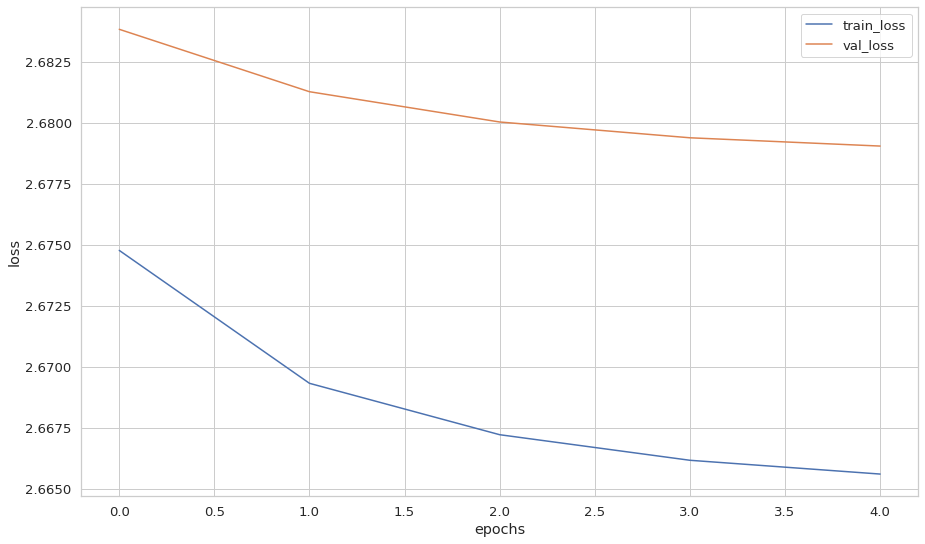

f1_score: 0.3


In [107]:
plot_losses(alexnet_history, alexnet)

Результат не очень. Кажется, делаю что-то не так, но пока что не успел разобраться

Попробую использовать vgg-19 с batchnorm

In [119]:
vgg19_bn = models.vgg19_bn(pretrained=True)

In [120]:
vgg19_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [127]:
vgg19_bn.classifier[6] = nn.Linear(4096, num_features)

# замораживаю параметры всех слоёв кроме последних 7
for param in model.features[:-7].parameters():
    param.requires_grad = False

vgg19_bn = vgg19_bn.to(DEVICE)

loss_fn = nn.CrossEntropyLoss()
vgg19_bn_optimizer = torch.optim.AdamW(vgg19_bn.classifier.parameters(), lr=0.001)
vgg19_bn_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=vgg19_bn_optimizer, gamma=0.5)

In [122]:
vgg19_bn

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [129]:
vgg19_bn_history = train(train_dataset, val_dataset, model=vgg19_bn, criterion=loss_fn, optimizer=vgg19_bn_optimizer, scheduler=vgg19_bn_scheduler, epochs=3, batch_size=32)

epoch:   0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: ignored

In [133]:
del vgg19_bn

In [136]:
torch.cuda.empty_cache()

In [137]:
!nvidia-smi

Fri Dec 24 18:06:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    73W / 149W |  10742MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Не хватает памяти

Что-то сделать уже не успеваю, поэтому пробую отправить ответы vgg16 и среднее из vgg16 + alexnet

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [130]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [139]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)
probs1 = predict(model, test_loader)
probs2 = predict(alexnet, test_loader)

probs = np.mean( np.array([ probs1, probs2 ]), axis=0 )  # взял предасказания двух моделей и усреднил

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

In [ ]:
my_submit.to_csv('gdrive/My Drive/simple_cnn_baseline.csv', index=False)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

Итого, лучший score дали предсказания от vgg16: 0.95430